In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random


In [2]:
input_dir="C:\\Users\\marco\\Downloads\\archive(4)"
print(os.listdir(input_dir))

['artists.csv', 'images', 'resized']


In [3]:
artists_path = os.path.join(input_dir, 'artists.csv')
artists = pd.read_csv(artists_path)
artists.shape

(50, 8)

# Data Processing

In [4]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Durer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223

In [5]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [6]:
# Explore images of top artists
images_dir = os.path.join(input_dir, 'images\\images')
artists_dirs = os.listdir(images_dir)
artists_top['name'] = artists_top['name'].str.replace(' ', '_')
artists_top_name = artists_top['name'].tolist()
print(artists_top_name)

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Vincent_van_Gogh
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Edgar_Degas
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Pablo_Picasso
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Pierre-Auguste_Renoir
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Albrecht_Durer
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Paul_Gauguin
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Francisco_Goya
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Rembrandt
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Alfred_Sisley
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Titian
Found --> C:\Users\marco\Downloads\archive(4)\images\images\Marc_Chagall


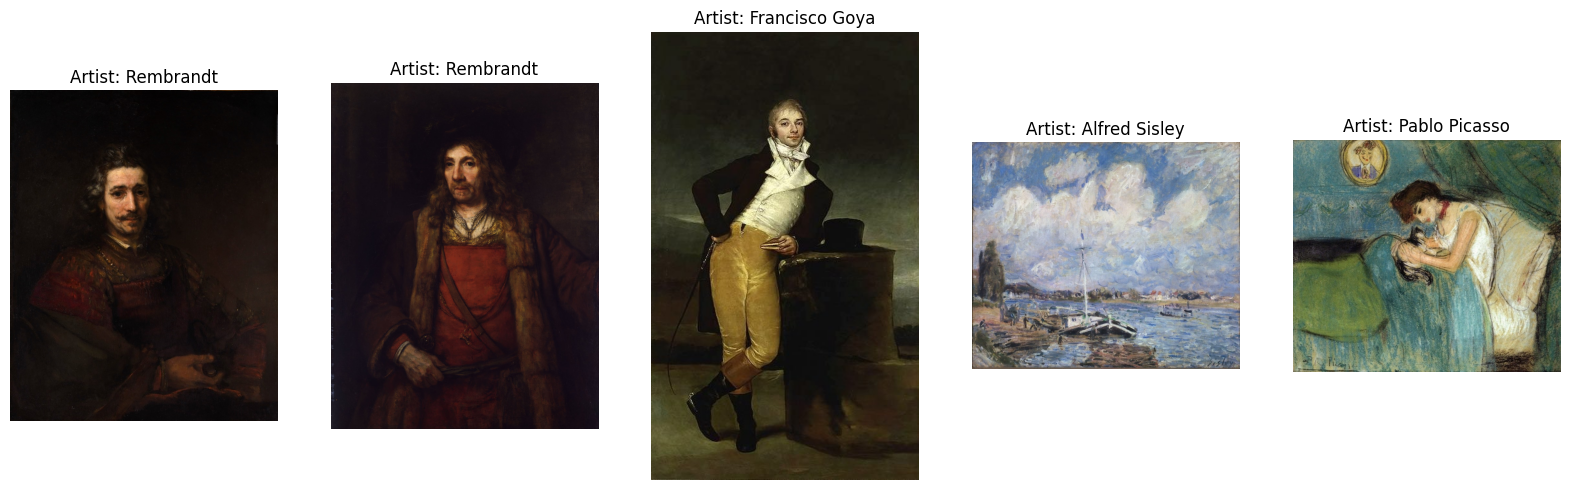

In [7]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()



In [8]:
# Numero di classi
n_classes = len(artists_top_name)
print("Numero di classi:", n_classes)

# Controlla la lista delle classi
print("Class names to be used:", artists_top_name)

# Funzione per caricare e filtrare il dataset
def create_filtered_dataset(directory, class_names, validation_split=0.2, subset='training', seed=123, image_size=(224, 224), batch_size=32):
    try:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            validation_split=validation_split,
            subset=subset,
            seed=seed,
            image_size=image_size,
            batch_size=batch_size,
            class_names=class_names  # Specifica le classi di interesse
        )
        return dataset
    except Exception as e:
        print(f"Error creating dataset for {subset}: {e}")
        return None

# Carica i dataset di training e validazione
train_dataset = create_filtered_dataset(images_dir, artists_top_name, subset='training')
validation_dataset = create_filtered_dataset(images_dir, artists_top_name, subset='validation')

if train_dataset and validation_dataset:
    # Stampa i nomi delle classi e il numero di classi
    print("Class names in training dataset:", train_dataset.class_names)
    print("Class names in validation dataset:", validation_dataset.class_names)

    # Funzione di augmentazione dei dati
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        return image, label

    # Applica augmentazione e prefetch ai dataset
    try:
        train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    except Exception as e:
        print("Error processing dataset:", e)

    # Funzione per filtrare le etichette
    def filter_labels(dataset, num_classes):
        try:
            dataset = dataset.filter(lambda image, label: tf.reduce_all(tf.less_equal(label, num_classes - 1)))
            return dataset
        except Exception as e:
            print(f"Error filtering labels: {e}")
            return None

    # Applica il filtro alle etichette
    train_dataset = filter_labels(train_dataset, n_classes)
    validation_dataset = filter_labels(validation_dataset, n_classes)

    # Verifica le etichette nel dataset filtrato
    def check_dataset_labels(dataset, num_classes):
        try:
            for image_batch, label_batch in dataset.take(1):  # Usa take(1) per limitare il numero di batch
                unique_labels = np.unique(label_batch.numpy())
                print("Batch of labels:", label_batch.numpy())
                print("Unique labels in batch:", unique_labels)
                if any(label >= num_classes for label in unique_labels):
                    print("Warning: Found labels outside the expected range.")
                break
        except Exception as e:
            print("Error checking dataset labels:", e)

    check_dataset_labels(train_dataset, n_classes)
    check_dataset_labels(validation_dataset, n_classes)
else:
    print("Datasets could not be loaded.")


Numero di classi: 11
Class names to be used: ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']
Found 4299 files belonging to 11 classes.
Using 3440 files for training.
Found 4299 files belonging to 11 classes.
Using 859 files for validation.
Class names in training dataset: ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']
Class names in validation dataset: ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']
Batch of labels: [4 9 3 5 0 3 5 8 7 8 0 1 3 3 3 1 1 7 5 0 5 8 9 0 8 0 1 1 0 1 2 0]
Unique labels in batch: [0 1 2 3 4 5 7 8 9]
Batch of labels: [1 3 1 4 6 8 4 0 1 9 4 9 0 6 1 3 9 6 3

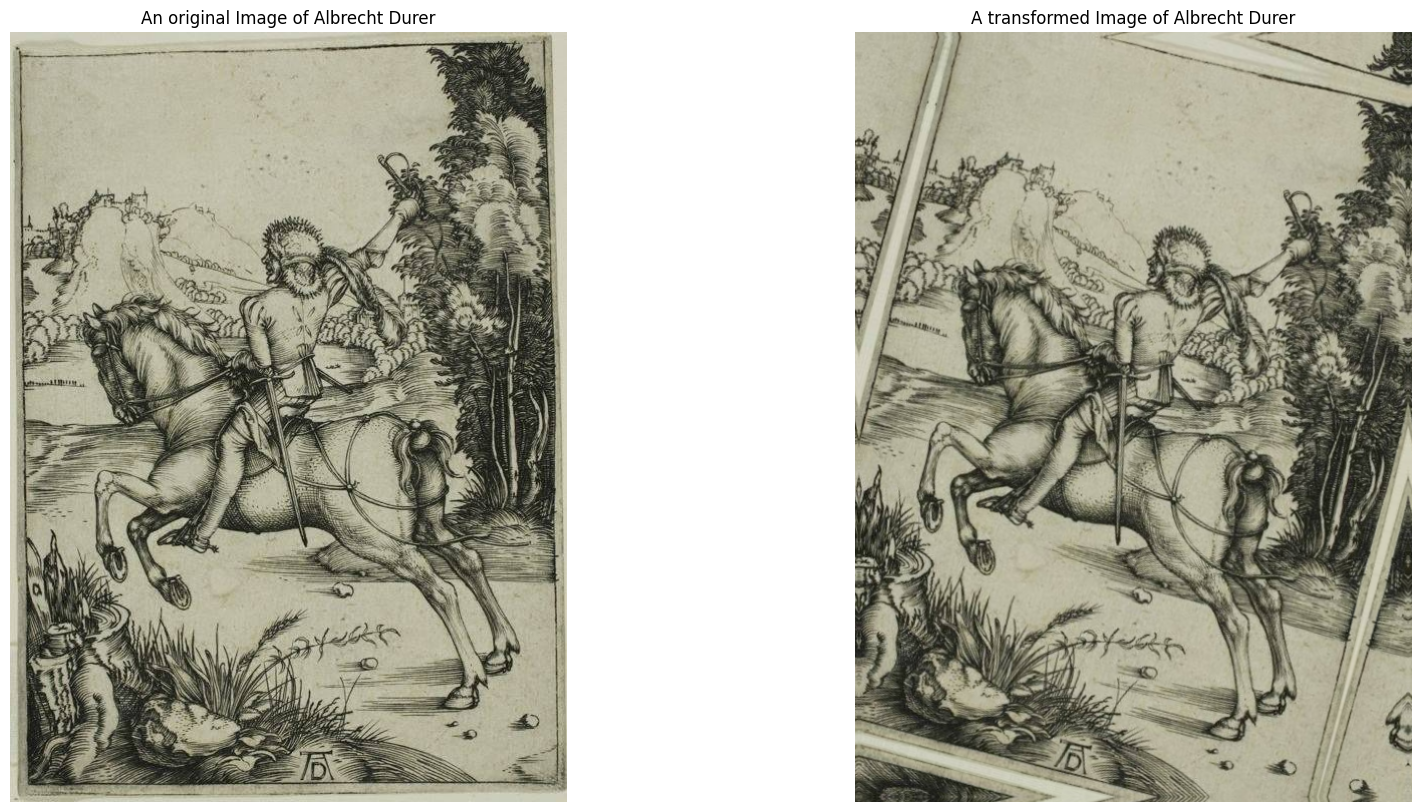

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Function to apply augmentation to a single image
def augment_image(image):
    image = tf.expand_dims(image, 0)  # Add batch dimension
    aug_image = data_augmentation(image)
    return tf.squeeze(aug_image, 0)  # Remove batch dimension

# Print a random painting and its random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure image is in the correct dtype
aug_image = augment_image(image)
axes[1].imshow(aug_image.numpy())
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [10]:
'''
from tensorflow.keras.applications import MobileNetV3Small
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
'''

"\nfrom tensorflow.keras.applications import MobileNetV3Small\nbase_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')\nbase_model.trainable = False\n\nmodel = Sequential([\n    base_model,\n    GlobalAveragePooling2D(),\n    Dense(11, activation='softmax')\n])\n\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n"

In [11]:
from tensorflow.keras.applications import MobileNetV3Small

# Carica il modello base
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Costruisci il modello
X = base_model.output
X = GlobalAveragePooling2D()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(11, activation='softmax')(X)  # Assicurati che il numero di classi sia corretto

model = Model(inputs=base_model.input, outputs=output)



In [12]:
# Configura l'optimizer e la compilazione del modello
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # Usa sparse_categorical_crossentropy per etichette intere
              metrics=['accuracy'])


In [13]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [14]:
import numpy as np

def check_labels(dataset):
    labels = []
    for image_batch, label_batch in dataset:
        labels.extend(label_batch.numpy())
    labels = np.array(labels)
    print("Unique labels in the dataset:", np.unique(labels))

check_labels(train_dataset)
check_labels(validation_dataset)


Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10]
Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10]


In [15]:
history1 = model.fit(
    train_dataset,
    epochs=n_epoch,
    validation_data=validation_dataset,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weights  # Rimuovi se non necessario
)

Epoch 1/10


    107/Unknown 19s 93ms/step - accuracy: 0.1536 - loss: 2.3791

c:\Users\marco\miniconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.1550 - loss: 2.3754 - val_accuracy: 0.3376 - val_loss: 2.1124 - learning_rate: 1.0000e-04
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.3745 - loss: 1.8343 - val_accuracy: 0.4563 - val_loss: 1.8946 - learning_rate: 1.0000e-04
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.4770 - loss: 1.6282 - val_accuracy: 0.5076 - val_loss: 1.7530 - learning_rate: 1.0000e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.5186 - loss: 1.5039 - val_accuracy: 0.5495 - val_loss: 1.6556 - learning_rate: 1.0000e-04
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.5532 - loss: 1.4156 - val_accuracy: 0.5751 - val_loss: 1.5753 - learning_rate: 1.0000e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.5657 - loss: 1.3407 - val_accuracy: 0.5984 - val_loss: 1.5087 - learning_rate: 1.0000e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - 

In [16]:
for layer in model.layers[:50]:
        layer.trainable = True

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, 
                  metrics=['accuracy'])

history2 = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=n_epoch,
        shuffle=True,
        verbose=1,
        callbacks=[reduce_lr, early_stop]
    )


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.5906 - loss: 1.4308 - val_accuracy: 0.5984 - val_loss: 1.3252 - learning_rate: 1.0000e-04
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - accuracy: 0.6723 - loss: 1.2674 - val_accuracy: 0.6123 - val_loss: 1.3282 - learning_rate: 1.0000e-04
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 311ms/step - accuracy: 0.7147 - loss: 1.1881 - val_accuracy: 0.6100 - val_loss: 1.3255 - learning_rate: 1.0000e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.7379 - loss: 1.1246 - val_accuracy: 0.6193 - val_loss: 1.3126 - learning_rate: 1.0000e-04
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.7686 - loss: 1.0600 - val_accuracy: 0.6438 - val_loss: 1.2576 - learning_rate: 1.0000e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 332ms/step - accuracy: 0.7882 - loss: 1.0203 - val_accuracy: 0.6752 - val_loss: 1.2041 - learning_rate: 1.0000e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 32

In [17]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['learning_rate'] = history1.history['learning_rate'] + history2.history['learning_rate']

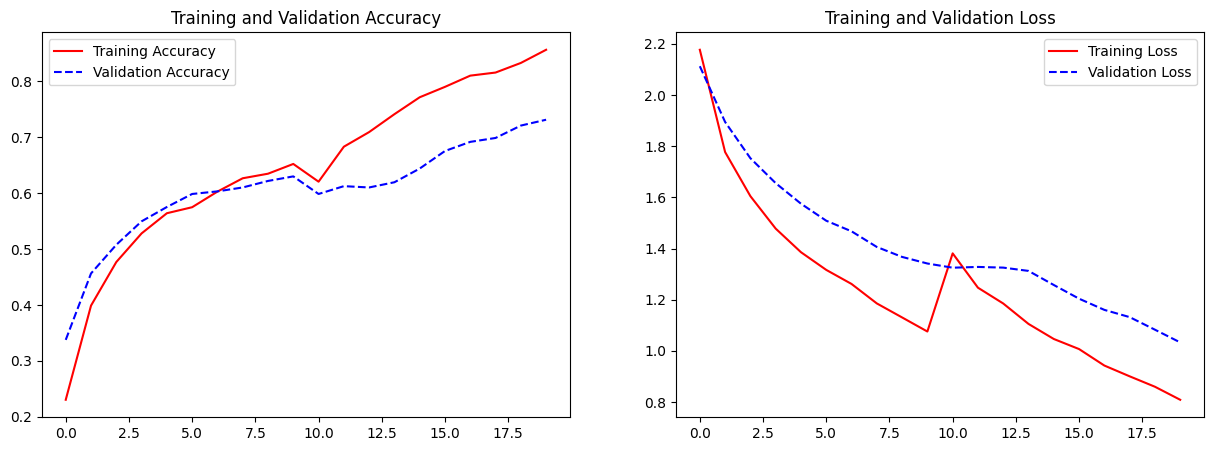

In [18]:
# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [19]:
# Prediction accuracy on train data
score = model.evaluate(train_dataset, verbose=1)
print("Prediction accuracy on train data =", score[1])

108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.8459 - loss: 0.8002
Prediction accuracy on train data = 0.8406976461410522


In [20]:
# Prediction accuracy on CV data
score = model.evaluate(validation_dataset, verbose=1)
print("Prediction accuracy on CV data =", score[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7381 - loss: 1.0533
Prediction accuracy on CV data = 0.7310826778411865


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━

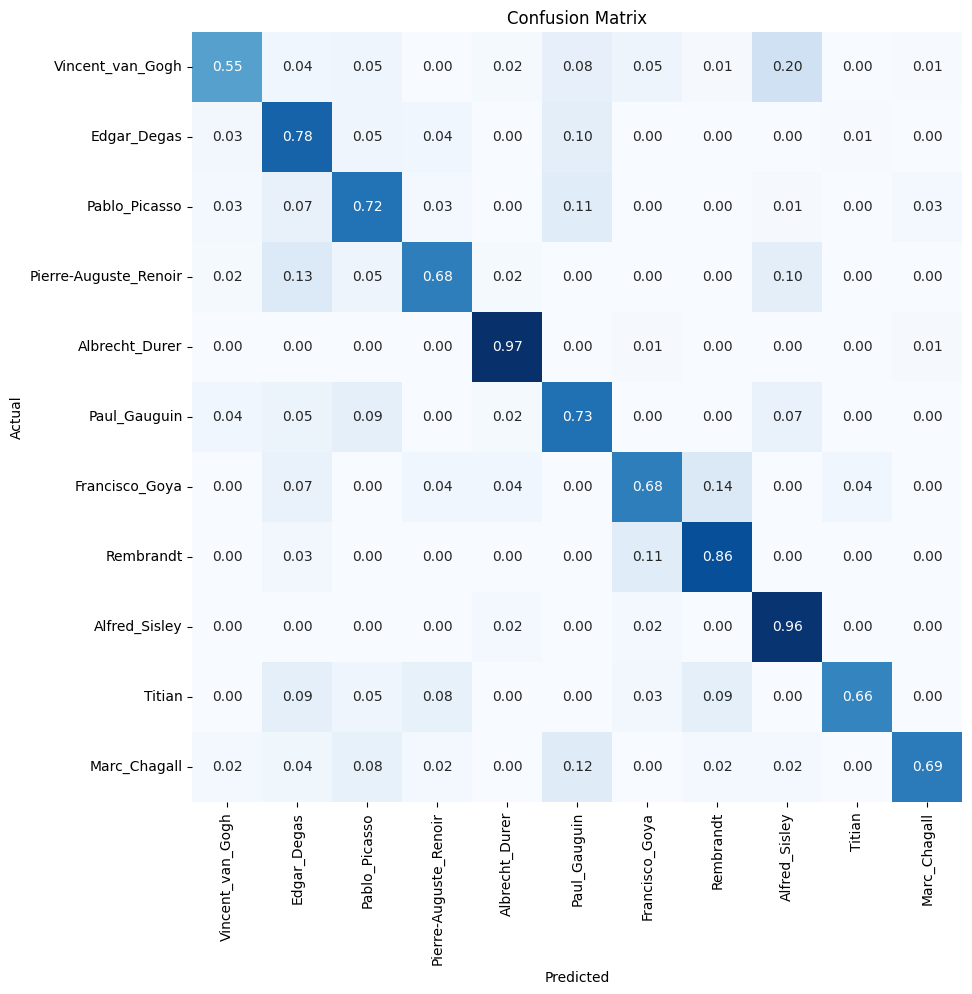

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definizione delle etichette di classe
tick_labels = artists_top_name

def show_classification_report(model, dataset, class_names, batch_size=32):
    y_true = []
    y_pred = []

    # Estrai etichette vere e previsioni dal dataset
    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Genera il rapporto di classificazione
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Genera la matrice di confusione
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    # Normalizza la matrice di confusione
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot della matrice di confusione
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Usa la funzione aggiornata per mostrare il rapporto di classificazione e la matrice di confusione
show_classification_report(model, validation_dataset, tick_labels)


Artists top name: ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


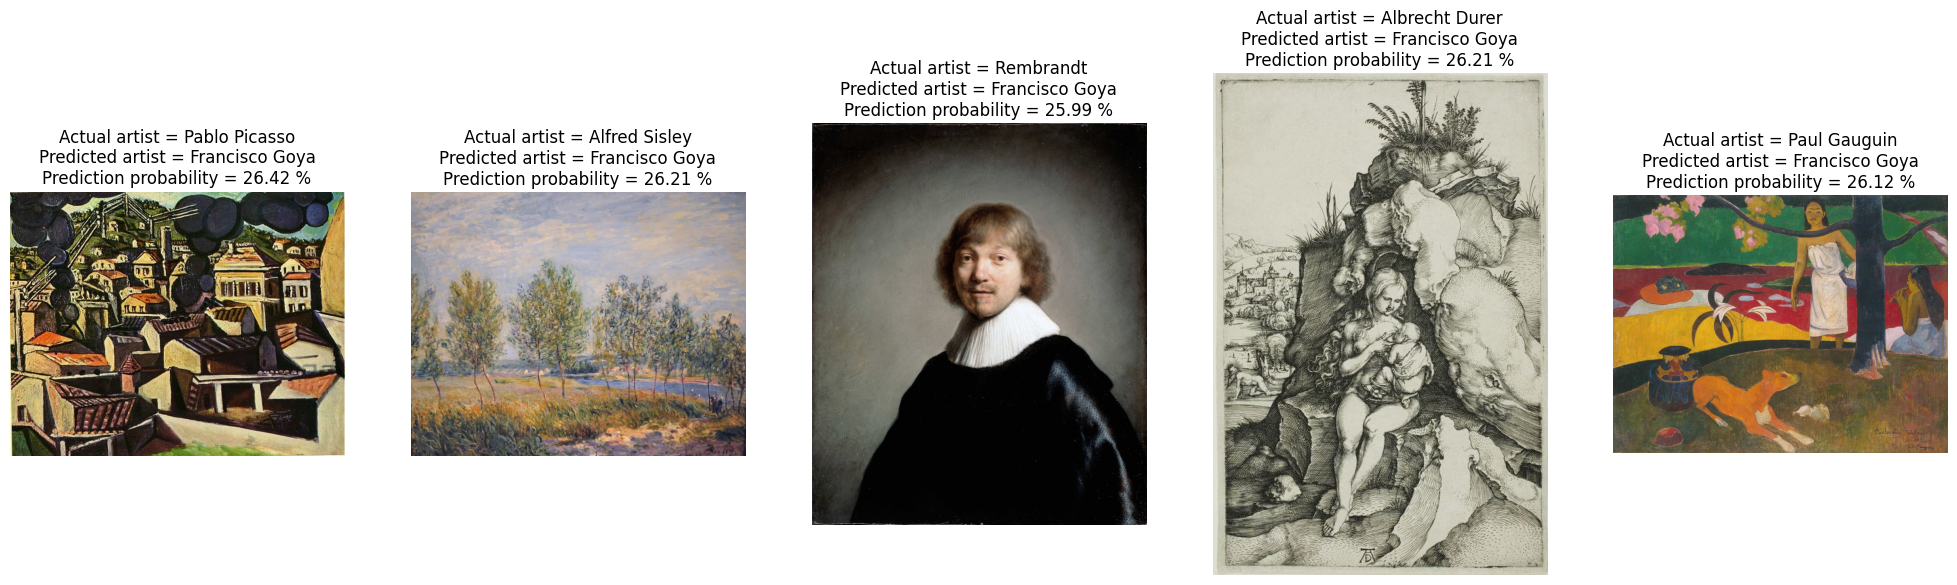

In [36]:
# Prediction
from keras.preprocessing import *
# Definisci la dimensione di input dell'immagine utilizzata durante l'addestramento del modello
input_shape = (224, 224, 3)

# Verifica se artists_top_name è coerente
print("Artists top name:", artists_top_name)

def preprocess_image(img_path, img_size=(224, 224)):
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalizzazione
    img_array = np.expand_dims(img_array, axis=0)  # Aggiunge una dimensione per il batch
    return img_array

# Creazione della mappatura delle classi
class_names = ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 
               'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 
               'Titian', 'Marc_Chagall']

labels = {i: class_name for i, class_name in enumerate(class_names)}

# Predizione
n = 5
fig, axes = plt.subplots(1, n, figsize=(25, 10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Preprocessa l'immagine di test
    test_image = preprocess_image(random_image_file, img_size=input_shape[0:2])

    # Predici l'artista
    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    # Crea il titolo con le informazioni di predizione
    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
        .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                prediction_probability * 100)

    # Mostra l'immagine
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

In [37]:
print("Prediction array:", prediction)
print("Prediction index:", prediction_idx)
print("Class names:", class_names)
print("Artists top name:", artists_top_name)

Prediction array: [[0.07723083 0.06493294 0.07655652 0.03425484 0.03212494 0.05634604
  0.26118013 0.23508717 0.03093199 0.05581503 0.07553954]]
Prediction index: 6
Class names: ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']
Artists top name: ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian', 'Marc_Chagall']


C:\Users\marco\AppData\Local\Temp\ipykernel_14332\3337936992.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  web_image = imageio.imread(url)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted artist = Francisco Goya
Prediction probability = 26.077651977539062 %


C:\Users\marco\AppData\Local\Temp\ipykernel_14332\3337936992.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread(url))


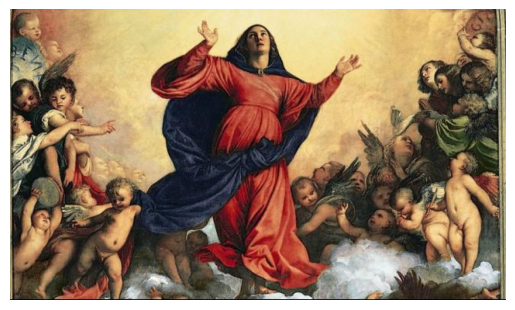

In [40]:
# Predict from web - this is an image of Titian.
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()